### Generic header ...

Utility functions were reduced to libits.py and removed from this notebook

In [1]:
import libits

In [4]:
import numpy as np
import pandas as pd
import shapely
import matplotlib
from matplotlib import pylab as plt
import pygeos
import geopandas as gpd
import pyproj
import contextily as ctx
import networkx as nx
import osmnx
import scipy as sc
import sklearn
import overpy
import tempfile
import os

from shapely.geometry import Point
from shapely.geometry import LineString

In [14]:
crs_gps = pyproj.CRS.from_epsg('4326')  # Merkator
crs_web = pyproj.CRS.from_epsg('3857')  # Pseudo-Merkator
crs_estonia = pyproj.CRS.from_epsg('3301')

In [5]:
overpass_client = overpy.Overpass()

In [8]:
query=\
'''[out:json];
area["ISO3166-1"="FI"]->.a;

way[power=line](area.a);
(._;>;);   // Resolve nodes
out geom;
'''

In [9]:
overpass_r = overpass_client.query(query)

In [10]:
df_nodes =\
pd.DataFrame([dict([(a,getattr(x,a)) for a in ['id','lat','lon']]) for x in overpass_r.nodes])\
    .set_index('id',drop=True)
df_nodes

,lat,lon
id,,
25413736,60.2044941,24.9320892
26456112,60.2615310,24.9718993
26456113,60.2588832,24.9723769
26456114,60.2560272,24.9728873
26456167,60.2536194,24.9732958
...,...,...
10148460415,65.2668620,25.6927049
10148495006,64.8633785,26.0490962
10148495011,64.9699144,26.2460040


In [11]:
df_ways_idx =\
pd.DataFrame(np.vstack([np.asarray([[w.id, n.id] for n in w.nodes])
                        for w in overpass_r.ways]),
             columns=['id','node'])\
    .set_index('id', drop=True)
df_ways_idx

,node
id,
5031651,9675572383
5031651,9675572384
5031651,1710214738
5031651,9675572385
5031651,1710214751
...,...
1108055430,8894549027
1108055430,8894549028
1108055430,8894549029


In [12]:
df_ways=\
    df_ways_idx.groupby('id').apply(lambda df: df.node.values)\
        .to_frame()\
        .rename(columns={0:'nodes'})
df_ways

,nodes
id,
5031651,"[9675572383, 9675572384, 1710214738, 967557238..."
7959145,"[1019905591, 1019905385, 1019905530, 101990572..."
8119193,"[1583318654, 1583318651, 5758021924, 253930039..."
9964102,"[1285025355, 81799901, 5741307459, 5741307457,..."
18617948,"[3995851358, 4017521730, 4017521731, 401752173..."
...,...
1107461444,"[10133316543, 10133316542, 10133316541, 101333..."
1107461445,"[385205058, 10133316547, 10133316548, 10133316..."
1107943144,"[10137544131, 10137544130, 10137544129, 101375..."


In [15]:
gdf_nodes = gpd.GeoDataFrame(
    df_nodes.assign(geometry=\
        df_nodes.groupby('id')\
            .apply(lambda df: df[['lon','lat']].values.reshape(-1))\
            .apply(Point))\
        .drop(columns=['lon','lat']),
    crs=crs_gps)
gdf_nodes

gdf_nodes

,geometry
id,
25413736,POINT (24.93209 60.20449)
26456112,POINT (24.97190 60.26153)
26456113,POINT (24.97238 60.25888)
26456114,POINT (24.97289 60.25603)
26456167,POINT (24.97330 60.25362)
...,...
10148460415,POINT (25.69270 65.26686)
10148495006,POINT (26.04910 64.86338)
10148495011,POINT (26.24600 64.96991)


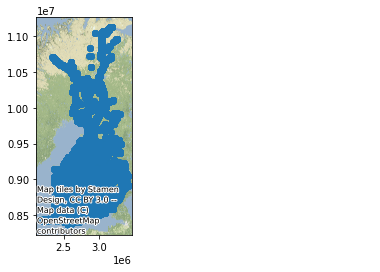

In [15]:
ax = gdf_nodes.to_crs(crs_web).plot()
ctx.add_basemap(ax=ax, zoom=9)

In [16]:
gdf_ways = gpd.GeoDataFrame(
    df_ways.assign(geometry=\
        df_ways.nodes.apply(lambda nodes: LineString(df_nodes.loc[nodes][['lon','lat']].values))),
    crs=crs_gps)
gdf_ways

,nodes,geometry
id,,
5031651,"[9675572383, 9675572384, 1710214738, 967557238...","LINESTRING (24.24837 61.35677, 24.24636 61.357..."
7959145,"[1019905591, 1019905385, 1019905530, 101990572...","LINESTRING (23.86311 61.45921, 23.86394 61.459..."
8119193,"[1583318654, 1583318651, 5758021924, 253930039...","LINESTRING (26.90550 60.59953, 26.90832 60.599..."
9964102,"[1285025355, 81799901, 5741307459, 5741307457,...","LINESTRING (25.57309 65.00337, 25.57324 65.003..."
18617948,"[3995851358, 4017521730, 4017521731, 401752173...","LINESTRING (27.04884 68.14589, 27.04775 68.147..."
...,...,...
1107461444,"[10133316543, 10133316542, 10133316541, 101333...","LINESTRING (25.13380 62.28041, 25.13391 62.280..."
1107461445,"[385205058, 10133316547, 10133316548, 10133316...","LINESTRING (25.13367 62.28015, 25.13382 62.280..."
1107943144,"[10137544131, 10137544130, 10137544129, 101375...","LINESTRING (25.29499 63.80764, 25.29483 63.808..."


In [25]:
def get_voltage(x):
    try:
        vol = x.tags['voltage']
        if ';' in vol:
            vol = vol.split(';')[0]
        return vol
    except:
        return 0

In [30]:
def get_cables(x):
    try:
        num = x.tags['cables']
        if num == '2x2':
            num = 4
        return num
    except:
        return 1

In [31]:
df_capacity = pd.DataFrame([dict([('voltage',get_voltage(x)), ('cable_num',get_cables(x)), ('id',x.id)]) for x in overpass_r.ways]).set_index('id', drop=True)

In [36]:
gdf_ways['voltage'] = pd.to_numeric(df_capacity.voltage)
gdf_ways['cable_num'] = pd.to_numeric(df_capacity.cable_num)

In [38]:
# assumed
max_amp = 700
gdf_ways['watts'] = gdf_ways.voltage * gdf_ways.cable_num * max_amp

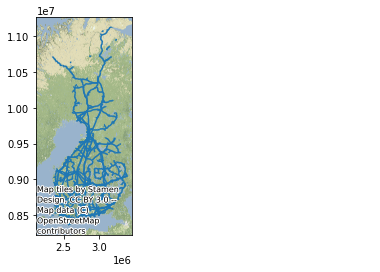

In [17]:
ax=gdf_ways.to_crs(crs=crs_web).plot()
ctx.add_basemap(ax=ax, zoom=9)

In [81]:
power_plants = pd.read_csv('plants.csv')

/tmp/ipykernel_33879/4128611383.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  power_plants = pd.read_csv('plants.csv')


In [82]:
power_plants = power_plants.loc[power_plants.country == 'FIN']

In [83]:
power_plants['geometry'] = power_plants.apply(lambda plant: Point(plant.longitude, plant.latitude),axis=1)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/tmp/ipykernel_33879/764246701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_plants['geometry'] = power_plants.apply(lambda plant: Point(plant.longitude, plant.latitude),axis=1)


In [84]:
power_plants_gdf = gpd.GeoDataFrame(power_plants, crs=crs_gps, geometry='geometry')

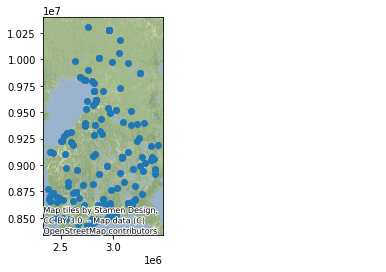

In [74]:
ax=power_plants_gdf.to_crs(crs_web).plot()
ctx.add_basemap(ax=ax, zoom=9)

In [85]:
power_plants_gdf = gpd.sjoin_nearest(power_plants_gdf, gdf_nodes, distance_col='distance')

/home/till/.local/lib/python3.10/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [89]:
power_plants_gdf['new_geometry'] = power_plants_gdf.apply(lambda plant: gdf_nodes.loc[plant.index_right],axis=1)

In [92]:
gdf_power_plants_on_grid = gpd.GeoDataFrame(power_plants_gdf, geometry='new_geometry', crs=crs_gps)

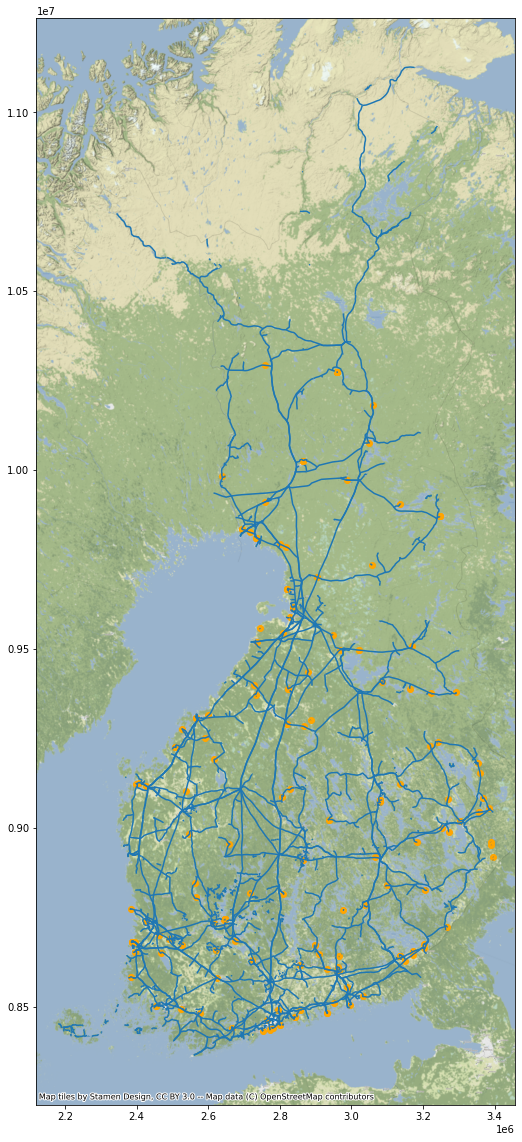

In [96]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

gdf_ways.to_crs(crs=crs_web).plot(ax=ax)
gdf_power_plants_on_grid.to_crs(crs=crs_web).plot(ax=ax,color='orange')
ctx.add_basemap(ax=ax, zoom=9)

In [47]:
# Break down to road segments
#    Way can contain >=2 nodes
#    Segment contains exactly 2 nodes (start, end)
# Index the segment of each way
def road2segs(df_road):
    return \
        pd.DataFrame(dict(
            zip(['power_line','seg','start_node','end_node', 'watts'],
                np.asarray(list(
                    zip((np.ones(len(df_road.nodes)-1)*df_road.name).astype(np.int64),
                         np.arange(len(df_road.nodes)-1),
                         df_road.nodes[:-1],
                         df_road.nodes[1:]))).T))).set_index(['power_line','seg'])

In [48]:
df_edges =\
    pd.concat([road2segs(gdf_ways.loc[way]) for way in gdf_ways.index])

gdf_edges=\
    gpd.GeoDataFrame(
        df_edges.assign(geometry=\
            df_edges\
                .join(gdf_nodes, on='start_node')\
                .rename(columns={'geometry':'vtx1'})\
                .join(gdf_nodes, on='end_node')\
                .rename(columns={'geometry':'vtx2'})\
                [['vtx1','vtx2']].T.apply(LineString)),
        crs=crs_gps)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [51]:
gdf_edges = gdf_edges.join(gdf_ways['watts'], on='power_line')

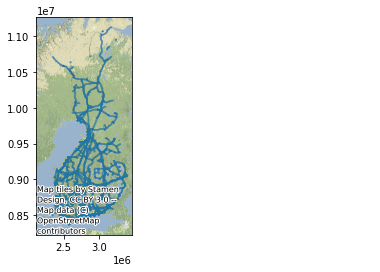

In [158]:
ax=gdf_edges.to_crs(crs=crs_web).plot()
ctx.add_basemap(ax=ax, zoom=9)

In [153]:
gdf_power_plants_on_grid = gdf_power_plants_on_grid.rename(columns={'index_right':'node_id', 'geometry':'original_geometry', 'new_geometry':'geometry'})

In [ ]:
#######################################
gdf_nodes
gdf_edges
gdf_power_plants_on_grid
#######################################

In [ ]:
#traverse graph to kick out

In [53]:
import networkx as nx
G = nx.Graph()

In [54]:
G.add_nodes_from(gdf_nodes.index, location=gdf_nodes.geometry)

In [55]:
nx.write_graphml(G, 'graph.xml')

TypeError: GraphML does not support type <class 'type'> as data values.

In [184]:
gdf_edges['edge'] = gdf_edges.apply(lambda edge: (edge.start_node,edge.end_node),axis=1)


In [ ]:
gdf_edg

In [186]:
gdf_edges.reset_index()
gdf_edges = gdf_edges.set_index('edge')

In [189]:
gdf_edges = gdf_edges.drop(['start_node', 'end_node', 'geometry'],axis=1)

In [195]:
gdf_edges

start_node    end_node  \
power_line seg                           
5031651    0    9675572383  9675572384   
           1    9675572384  1710214738   
           2    1710214738  9675572385   
           3    9675572385  1710214751   
           4    1710214751  9675572386   
...                    ...         ...   
1108055430 0    8894549025  8894549026   
           1    8894549026  8894549027   
           2    8894549027  8894549028   
           3    8894549028  8894549029   
1109074765 0     314558180  1789872614   

                                                         geometry  
power_line seg                                                     
5031651    0    LINESTRING (24.24837 61.35677, 24.24636 61.35726)  
           1    LINESTRING (24.24636 61.35726, 24.24470 61.35822)  
           2    LINESTRING (24.24470 61.35822, 24.24292 61.35926)  
           3    LINESTRING (24.24292 61.35926, 24.23960 61.36035)  
           4    LINESTRING (24.23960 61.36035, 24.23584 61.36159)  
...                                                           ...  
1108055430 0    LINESTRING (19.92212 60.12455, 19.92190 60.12289)  
           1    LINESTRING (19.92190 60.12289, 19.92298 60.12133)  
           2    LINESTRING (19.92298 60.12133, 19.92398 60.11962)  
           3    LINESTRING (19.92398 60.11962, 19.92482 60.11832)  
1109074765 0    LINESTRING (22.82098 62.80105, 22.82192 62.79965)  

[100460 rows x 3 columns]

In [196]:
G.add_edges_from(gdf_edges.start_node, gdf_edges.end_node)

TypeError: Graph.add_edges_from() takes 2 positional arguments but 3 were given

In [193]:
import json

with open('grid.json', 'r') as infile1:
    F = nx.node_link_graph(json.loads(infile1.read()))
D = nx.DiGraph(F)
D.add_node(0,power=0) # source
D.add_node(1,power=0) # sink

for n in D:
    power = D.nodes[n]['power']
    if power > 0:
        # producers
        D.add_edge(0,n,capacity=power)
    if power < 0:     
        # consumers
        D.add_edge(n,1,capacity=power)

In [207]:
import sys
sys.setrecursionlimit(100000)

def dfs(visited,G_orig,u):
    visited.add(u)

    for neighbor in G_orig.neighbors(u):
        if (neighbor not in visited):
            if (G_orig.nodes[neighbor]['power'] == 0):
                dfs(visited,G_orig,neighbor)
            if (G_orig.nodes[neighbor]['power'] != 0):
                # other node to keep
                #print(start, neighbor)
                cap = G_orig.edges[u,neighbor]['capacity']
                create_new_edge(start,neighbor,cap)
        if (neighbor in visited) and (G_orig.nodes[neighbor]['power'] != 0) and (neighbor != start):
            cap = G_orig.edges[u,neighbor]['capacity']
            update_edge(start,neighbor,cap)

In [202]:
def create_new_edge(u,v,cap):
    G.add_edge(u,v,capacity=cap)

def update_edge(u,v,cap):
    G[u][v]['capacity'] += cap    

In [208]:
with open('grid.json', 'r') as infile1:
    G = nx.node_link_graph(json.loads(infile1.read()))
G_orig = nx.Graph(G)

for n in G_orig:
    if G_orig.nodes[n]['power'] != 0:    
        visited = set()
        start = n
        dfs(visited,G_orig,n)

In [209]:
kick=[]
for n in G:
    if G.nodes[n]['power'] == 0:
        kick.append(n)
        
for n in kick:
    G.remove_node(n)

In [212]:
len(list(G.nodes))

411

In [219]:
import json
with open('grid_contracted.json', 'w') as outfile1:
    outfile1.write(json.dumps(nx.node_link_data(G)))

In [238]:
b = nx.to_pandas_edgelist(G)
b

,source,target,capacity
0,246529612,246529614,462000000
1,246529612,294854486,462000000
2,249565622,4836046690,77000000
3,249565622,538122764,77000000
4,252167900,1082948540,462000000
...,...,...,...
3983,8661869141,9875973160,231000000
3984,9315860509,9422370488,840000000
3985,9338582017,9650996572,231000000
3986,9510316607,10035810249,231000000


In [237]:
a = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
a['geometry'] = a.apply(lambda node: Point(node.lon, node.lat),axis=1)
a = gpd.GeoDataFrame(a, geometry='geometry', crs=crs_gps)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [241]:
b['geo'] = b.apply(lambda path: LineString([a.loc[path.source]['geometry'], a.loc[path.target]['geometry']]), axis=1)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [243]:
b = gpd.GeoDataFrame(b, geometry='geo', crs=crs_gps)

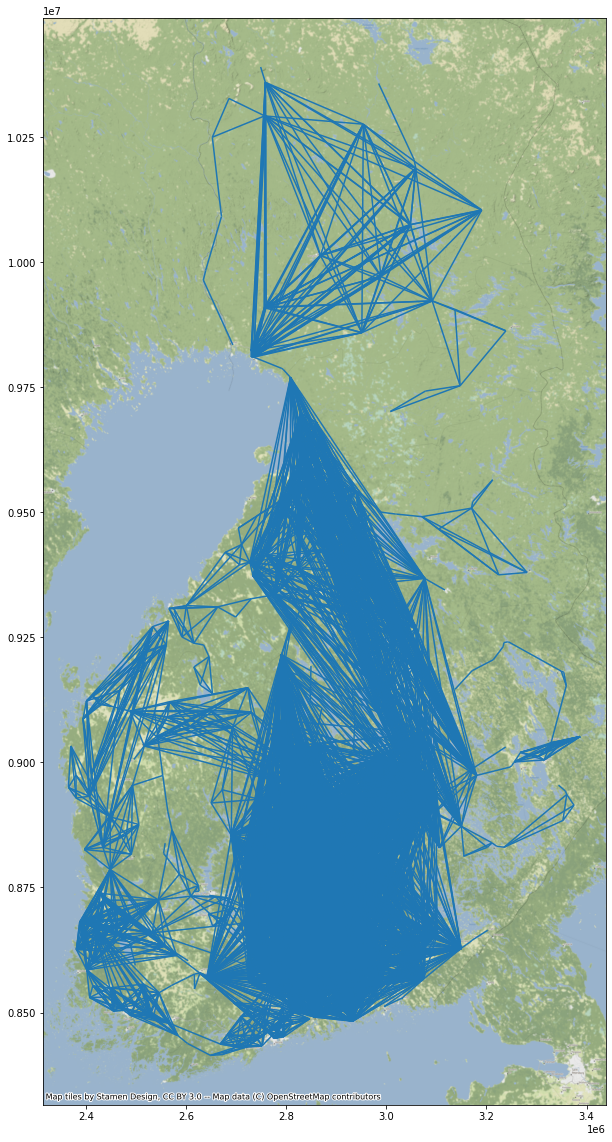

In [246]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
b.to_crs(crs_web).plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=9)

# Lab 006
## Transportation Networks: Representation and Route Planning

#### Required CRS constants

In [ ]:
crs_gps = pyproj.CRS.from_epsg('4326')  # Merkator
crs_web = pyproj.CRS.from_epsg('3857')  # Pseudo-Merkator
crs_estonia = pyproj.CRS.from_epsg('3301')

#### Fetching the Tartu administrative boudaries

In [ ]:
# Relation tag spec.
rel_tartu_tags= {'name':'Tartu linn',
                 'alt_name':'Tartu',
                 'type':'boundary',
                 'boundary':'administrative',
                 'admin_level':'9'}


In [ ]:
# Fetch the possible shapes for Tartu
gdf_tartu_soft = osmnx.geometries_from_place('Tartu linn',tags=rel_tartu_tags)
ax = gdf_tartu_soft.to_crs(crs=crs_web).plot(edgecolor='blue', alpha=.3)
ctx.add_basemap(ax=ax, zoom=9)

In [ ]:
gdf_tartu_soft

In [ ]:
# Select only the Tartu city districts (leave aside everything else)
gdf_tartu_quarters=\
gdf_tartu_soft\
    .reset_index()\
    .set_index(['element_type','place','osmid'])\
    .loc['relation']\
    .loc['quarter']\
    .to_crs(crs=crs_web)
ax = gdf_tartu_quarters\
    .plot(edgecolor='blue', alpha=.3)
for rel in gdf_tartu_quarters.index:
    lon,lat = np.asarray(gdf_tartu_quarters.centroid.loc[rel].xy)
    ax.text(x=lon,y=lat,s=gdf_tartu_quarters.loc[rel]['name'])
ctx.add_basemap(ax=ax, zoom=12)

#### Selecting area of interest

In [ ]:
gdf_aoi_m =\
gdf_tartu_quarters\
    .reset_index()\
    .set_index(['name','osmid'])\
    .loc[['Kesklinn','Ülejõe','Karlova','Supilinn','Annelinn']]
ax = gdf_aoi_m.plot(edgecolor='blue', alpha=.3)
ctx.add_basemap(ax=ax, zoom=14)

In [102]:
from shapely.ops import unary_union

In [ ]:
# Union all the districts to get the Tartu boundary
p0_tartu = unary_union(list(gdf_tartu_quarters.to_crs(crs=crs_gps).geometry))
p0_tartu

In [ ]:
# Union the selected districts to get the area of interest
p1_aoi = unary_union(list(gdf_aoi_m.to_crs(crs=crs_gps).geometry))
print(p1_aoi)

### Loading graph

In [ ]:
g1_aoi = osmnx.graph_from_polygon(p1_aoi)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_aoi_m.to_crs(crs=crs_gps).plot(ax=ax, edgecolor='yellow', alpha=.3)
ax.set_title('Area of interest, road graph')

ctx.add_basemap(ax=ax, crs=crs_gps, zoom=14)
osmnx.plot_graph(g1_aoi, ax=ax, bgcolor='none', node_color='none', node_size=1,
                 edge_color='blue', edge_linewidth=.7)
plt.show()

#### Basic graph statistics

In [ ]:
osmnx.basic_stats(g1_aoi)

#### Set the source/destination

Lookup the building shapes for some addresses in Tartu

In [ ]:
gdf_delta = osmnx.geocode_to_gdf('Narva mnt. 18, Tartu, Estonia')
gdf_delta

In [ ]:
gdf_ronmin = osmnx.geocode_to_gdf('Tehase 21, Tartu, Estonia')
gdf_ronmin

In [ ]:
# Combine discovered building shapes, assign labels and path direction
gdf_addr = gpd.GeoDataFrame(pd.concat([gdf_delta, gdf_ronmin]))\
    .assign(label=['DELTA','RonMin'], path=['start','stop'])\
    .set_index('path')\
    .to_crs(crs=crs_web)
gdf_addr

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_addr.plot(ax=ax, facecolor='red')
ax.set_title('Shortest path lookup init...')
gdf_aoi_m.plot(ax=ax, edgecolor='blue', alpha=.3)
for rel in gdf_addr.index:
    lon,lat = np.asarray(gdf_addr.centroid.geometry.loc[rel].xy)
    ax.text(x=lon,y=lat,s=gdf_addr.loc[rel].label)
ctx.add_basemap(ax=ax, zoom=14)

#### Calculate the shortest path

In [ ]:
### Etract the coordinate of the corresponding building centroids
lons,lats=\
    np.vstack(gdf_addr.geometry.centroid.to_crs(crs=crs_gps)\
                  .apply(lambda gdf: np.asarray(gdf.xy).reshape(-1)).values).T
lons,lats

In [ ]:
# Find the closest nodes in a road graph
start, stop = osmnx.nearest_nodes(g1_aoi, lons, lats)

In [ ]:
# Calculate the route
route = osmnx.shortest_path(g1_aoi, start, stop)

In [ ]:
route.distance

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_aoi_m.to_crs(crs=crs_gps).plot(ax=ax, edgecolor='yellow', alpha=.3)
ax.set_title('Shortest path...')
gdf_addr.to_crs(crs=crs_gps).plot(ax=ax, facecolor='red')
#osmnx.plot_graph(g1_aoi, ax=ax, bgcolor='none', node_color='none', node_size=1,
#                  edge_color='gray', edge_linewidth=.7)
osmnx.plot_graph_route(g1_aoi, ax=ax, route=route, bgcolor='none', node_color='none', node_size=1,
                         edge_color='gray', edge_linewidth=.7, route_color='blue', orig_dest_size=1,
                          route_linewidth=2)
#ctx.add_basemap(ax=ax, crs=crs_gps, zoom=14)
plt.show()

### The same story, manual mode ...

So no osmnx no networkx ...

In [ ]:
overpass_client = overpy.Overpass()

In [ ]:
# Verify the query using OverPass Turbo: https://overpass-turbo.eu/
overpass_q =\
'''/* All the roads in the area of interest */
[out:json];
area["ISO3166-1"="EE"]->.eesti;
area(area.eesti)[name="Tartu maakond"]->.tartumaa;
area(area.tartumaa)[name="Tartu linn"]->.tartulinn;
area(area.tartulinn)[admin_level=9][alt_name="Tartu"]->.tartuold;
rel(area.tartuold)[type=boundary][place=quarter]
  	[name~"Ülejõe|Kesklinn|Karlova|Supilinn|Annelinn"];
map_to_area->.aoi;
(
rel(area.aoi)[type=boundary][place=quarter];
way(area.aoi)[highway];
);
// Collect geometries for ways and relations (omit adding nodes)
// out geom;
// ---
// Collect nodes for all the ways and relations
//   Geometries will be built manually
(._;>;);   // Resolve nodes
out body;  // Collect everything
'''

In [ ]:
# Collecting geometries

In [ ]:
overpass_r = overpass_client.query(overpass_q)

In [ ]:
# Let's start with nodes
len(overpass_r.nodes)

In [ ]:
# Collect nodes
df_nodes =\
pd.DataFrame([dict([(a,getattr(x,a)) for a in ['id','lat','lon']]) for x in overpass_r.nodes])\
    .set_index('id',drop=True)
df_nodes

In [ ]:
from shapely.geometry import Point

In [ ]:
# Prepare the geoframe
gdf_nodes = gpd.GeoDataFrame(
    df_nodes.assign(geometry=\
        df_nodes.groupby('id')\
            .apply(lambda df: df[['lon','lat']].values.reshape(-1))\
            .apply(Point))\
        .drop(columns=['lon','lat']),
    crs=crs_gps)
gdf_nodes

ax = gdf_nodes.to_crs(crs=crs_web).plot()
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
ax = gdf_nodes.to_crs(crs=crs_web).plot()
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Collect ways
len(overpass_r.ways)

In [ ]:
pd.DataFrame(overpass_r.ways)

In [ ]:
df_ways_idx =\
pd.DataFrame(np.vstack([np.asarray([[w.id, n.id] for n in w.nodes])
                        for w in overpass_r.ways]),
             columns=['id','node'])\
    .set_index('id', drop=True)
df_ways_idx

df_ways=\
    df_ways_idx.groupby('id').apply(lambda df: df.node.values)\
        .to_frame()\
        .rename(columns={0:'nodes'})
df_ways

In [ ]:
df_ways=\
    df_ways_idx.groupby('id').apply(lambda df: df.node.values)\
        .to_frame()\
        .rename(columns={0:'nodes'})
df_ways

In [ ]:
df_ways=\
    pd.concat([pd.DataFrame(w.tags,index=[w.id]) for w in overpass_r.ways])\
        .join(df_ways)
df_ways

In [ ]:
from shapely.geometry import LineString

In [ ]:
from shapely.geometry import LineString
gdf_ways = gpd.GeoDataFrame(
    df_ways.assign(geometry=\
        df_ways.nodes.apply(lambda nodes: LineString(df_nodes.loc[nodes][['lon','lat']].values))),
    crs=crs_gps)
gdf_ways

In [ ]:
ax=gdf_ways.to_crs(crs=crs_web).plot()
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Collect relations
len(overpass_r.relations)

In [ ]:
df_rel_idx=\
    pd.concat(
        [pd.concat([pd.DataFrame({'way':m.ref, 'role':m.role}, index=[r.id]) for m in r.members])
         for r in overpass_r.relations])
df_rel_idx

In [ ]:
# Collect relation attributes
df_rels = pd.concat([pd.DataFrame(r.tags,index=[r.id]) for r in overpass_r.relations])
df_rels

In [ ]:
# Skip the label-relations, take only outer-relations, compose way list for each relation
df_rels=\
    df_rels.assign(ways=\
        df_rel_idx\
            .reset_index()\
            .set_index(['role','index'])\
            .loc['outer']\
            .groupby('index')\
            .apply(lambda df: df.way.values))
df_rels

In [ ]:
# Add the relation labels
df_rels=\
    df_rel_idx\
        .reset_index()\
        .set_index(['role','index'])\
        .loc['label']\
        .rename(columns={'way':'label'})\
        .join(df_rels)
df_rels

In [ ]:
# Prepare geometry for each relation
from shapely.ops import polygonize

In [ ]:
list(polygonize(gdf_ways.loc[df_rels.iloc[0].ways].geometry.values))[0]

In [ ]:
gdf_rels=\
gpd.GeoDataFrame(
    df_rels.assign(geometry=\
        df_rels\
            .groupby('index')\
            .apply(lambda df_rel: list(polygonize(gdf_ways.loc[df_rel.ways.values[0]].geometry.values))[0])),
    crs=crs_gps)
gdf_rels

In [ ]:
np.vstack(gdf_nodes.to_crs(crs=crs_web).loc[gdf_rels.label].geometry.apply(lambda p: np.asarray(p.xy).reshape(-1)).values)

In [ ]:
ax=gdf_rels.to_crs(crs=crs_web).plot(edgecolor='blue', alpha=.3)
gdf_nodes.to_crs(crs=crs_web).loc[gdf_rels.label].plot(ax=ax)
for l,(lon,lat) in list(zip(
        gdf_rels.name.values,
        np.vstack(gdf_nodes\
                      .to_crs(crs=crs_web)\
                      .loc[gdf_rels.label]\
                      .geometry\
                      .apply(lambda p: np.asarray(p.xy)\
                                         .reshape(-1)).values))):
    ax.text(x=lon,y=lat,s=l)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Prepare the road network
# Exclude the contours from the ways geoframe (leave only roads)

In [ ]:
gdf_roads=\
    gdf_ways[~np.in1d(df_ways.index.values, np.hstack(gdf_rels.ways.values))]\
        .dropna(axis=1)
gdf_roads

In [ ]:
gdf_roads[['highway']].reset_index().set_index('highway').groupby('highway').apply(lambda x: len(x))

In [ ]:
fig,ax = plt.subplots(1,1)
gdf_rels.to_crs(crs=crs_web).plot(ax=ax, color='red', alpha=.3)
gdf_roads.to_crs(crs=crs_web).plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Break down to road segments
#    Way can contain >=2 nodes
#    Segment contains exactly 2 nodes (start, end)
# Index the segment of each way
def road2segs(df_road):
    return \
        pd.DataFrame(dict(
            zip(['road','seg','start','end'],
                np.asarray(list(
                    zip((np.ones(len(df_road.nodes)-1)*df_road.name).astype(np.int64),
                         np.arange(len(df_road.nodes)-1),
                         df_road.nodes[:-1],
                         df_road.nodes[1:]))).T))).set_index(['road','seg'])

df_road_segs =\
    pd.concat([road2segs(gdf_roads.loc[way]) for way in gdf_roads.index])
df_road_segs

gdf_road_segs=\
    gpd.GeoDataFrame(
        df_road_segs.assign(geometry=\
            df_road_segs\
                .join(gdf_nodes, on='start')\
                .rename(columns={'geometry':'vtx1'})\
                .join(gdf_nodes, on='end')\
                .rename(columns={'geometry':'vtx2'})\
                [['vtx1','vtx2']].T.apply(LineString)),
        crs=crs_gps)
gdf_road_segs

In [ ]:
road2segs(gdf_roads.iloc[0])

In [ ]:
# Remove the roads beyond the area of interes
p2_aoi = unary_union(list(gdf_rels.geometry.values))
p2_aoi

In [ ]:
gdf_road_segs = gdf_road_segs[~gdf_road_segs.intersection(p2_aoi).apply(lambda x: x.is_empty)]

In [ ]:
ax=gdf_road_segs.to_crs(crs=crs_web).plot()
gdf_rels.to_crs(crs_web).plot(ax=ax,color='red',alpha=.3)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Calculate edge distances (meters)
gdf_road_segs = gdf_road_segs.assign(dist=gdf_road_segs.to_crs(crs=crs_web).length)
gdf_road_segs

In [ ]:
# Prpare the graph structure
gdf_g0 = gdf_road_segs.reset_index().set_index(['start','end'])
gdf_g0

In [ ]:
# Check if we can fetch the neighbor nodes
gdf_g0.groupby('start').apply(lambda df_start: len(df_start))

In [ ]:
gdf_g0.loc[8220933]

In [ ]:
# Prepare the source-destination
# Verify the query using OverPass Turbo: https://overpass-turbo.eu/
overpass_q =\
'''/* All the roads in the area of interest */
[out:json];
area["ISO3166-1"="EE"]->.eesti;
area(area.eesti)[name="Tartu maakond"]->.tartumaa;
area(area.tartumaa)[name="Tartu linn"]->.tartulinn;
area(area.tartulinn)[admin_level=9][alt_name="Tartu"]->.tartuold;
rel(area.tartuold)[type=boundary][place=quarter]
  	[name~"Ülejõe|Karlova"];
map_to_area->.aoi;
(
way(area.aoi)[building];
);
// Collect nodes for all the ways and relations
//   Geometries will be built manually
(._;>;);   // Resolve nodes
out body;  // Collect everything
'''

In [ ]:
overpass_r = overpass_client.query(overpass_q)

In [ ]:
# Collect the addresses
df_addr = pd.concat([pd.DataFrame(w.tags,index=[w.id]) for w in overpass_r.ways])

In [ ]:
df_addr=\
    df_addr\
        .reset_index()\
        .set_index(['addr:street','addr:housenumber'])
df_addr

In [ ]:
# Collect building shapes
from shapely.geometry import Polygon

In [ ]:
gdf_buildings=\
    gpd.GeoDataFrame(
        [{'id':w.id,'geometry':Polygon([(n.lon,n.lat) for n in w.nodes])} for w in overpass_r.ways],
        crs=crs_gps)\
    .set_index('id')
gdf_buildings

In [ ]:
ax = gdf_buildings.to_crs(crs=crs_web).plot()
gdf_rels.to_crs(crs=crs_web).set_index('name').loc[['Ülejõe','Karlova']].plot(ax=ax, color='red', alpha=.3)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
gdf_path=\
    pd.concat([
        df_addr.loc['Narva mnt'].loc[['18']],
        df_addr.loc['Tehase'].loc[['21']]]
    ).set_index('index')\
    .assign(label=['DELTA','RonMin'])\
    .assign(path=['start','end'])\
    .dropna(axis=1)\
    .join(gdf_buildings)
gdf_path = gpd.GeoDataFrame(gdf_path)
gdf_path

In [ ]:
ax=gdf_path.to_crs(crs=crs_web).plot(color='red')
gdf_rels.set_index('name').to_crs(crs=crs_web).plot(ax=ax, color='blue', alpha=.3)
for rel in gdf_path.index:
    lon,lat = np.asarray(gdf_path.to_crs(crs=crs_web).centroid.loc[rel].xy).reshape(-1)
    ax.text(x=lon,y=lat,s=gdf_path.loc[rel].label)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
# Find the closes road ends
gdf_path_endnodes = gpd.GeoDataFrame(
    gdf_path.assign(geometry=gdf_path.to_crs(crs=crs_web).centroid)\
        .sjoin_nearest(gdf_nodes.to_crs(crs=crs_web))\
        .drop(columns=['geometry'])\
        .join(gdf_nodes, on='index_right'))
gdf_path_endnodes

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

gdf_path_endnodes.iloc[[0]].plot(ax=ax1)
gdf_path.iloc[[0]].plot(ax=ax1, color='red')
ctx.add_basemap(ax=ax1, crs=gdf_path.crs, zoom=17)

gdf_path_endnodes.iloc[[1]].plot(ax=ax2)
gdf_path.iloc[[1]].plot(ax=ax2, color='red')
ctx.add_basemap(ax=ax2, crs=gdf_path.crs, zoom=13)

In [ ]:
# Prepare bidirectional graph
gdf_g0_bi=\
    pd.concat([gdf_g0,
    gdf_g0.reset_index().rename(columns={'start':'end', 'end':'start'}).set_index(['start','end'])])
gdf_g0_bi

In [ ]:
# Implement Dijkstra
src,tgt = gdf_path_endnodes.index_right

# All the nodes (vertices in the graph)
# Table of previously visited nodes and correponding distances
df_dj = pd.DataFrame({'dist':np.inf, 'prev':None},
                     index=np.unique(gdf_road_segs[['start','end']].values))
# Init queue to all available nodes
q_dj = list(df_dj.index.values)

# Init src distance to 0
df_dj.loc[src] = 0

while len(q_dj) > 0:
    # Only use nodes currently in the queue
    df_qdj = df_dj.loc[q_dj]
    # Select the node with in minimal distance
    u = df_qdj.iloc[df_qdj.dist.argmin()].name
    # Terminate if target found
    if u == tgt:
        break
    # Remove selected node from the queue
    q_dj.remove(u)
    # Select neighbors of u
    uvs = gdf_g0_bi.loc[u].index
    # Only use those in the queue
    uvs = uvs[np.in1d(uvs, q_dj)]
    # Calculate alternative distance
    alt = gdf_g0_bi.loc[u].loc[uvs].dist+df_dj.loc[u].dist
    # Mask the neighbors with smaller alternative distance
    alt = alt[alt < df_dj.loc[alt.index].dist]
    # Assign previously visited nodes and alternative distances
    df_dj.loc[alt.index, 'prev'] = u
    df_dj.loc[alt.index, 'dist'] = alt

In [ ]:
df_dj[df_dj.dist < np.inf]

In [ ]:
df_dj.loc[tgt]

In [ ]:
# Collect the route
route = []
u = tgt
while u != src:
    route.append(u)
    u = df_dj.prev[u]


In [ ]:
gdf_route = gpd.GeoDataFrame({'geometry':[LineString(gdf_nodes.loc[route].geometry.values)]}, crs=crs_gps)
gdf_route

In [ ]:
ax=gdf_path.to_crs(crs=crs_web).plot(color='red')
gdf_rels.set_index('name').to_crs(crs=crs_web).plot(ax=ax, color='blue', alpha=.1)
for rel in gdf_path.index:
    lon,lat = np.asarray(gdf_path.to_crs(crs=crs_web).centroid.loc[rel].xy).reshape(-1)
    ax.text(x=lon,y=lat,s=gdf_path.loc[rel].label)
gdf_route.to_crs(crs=crs_web).plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)


In [ ]:
# Check how much Dijkstra did traverse
gdf_dj_explored=\
gpd.GeoDataFrame(
df_dj.reset_index()\
    .rename(columns={'index':'end','prev':'start'})\
    .set_index(['start','end'])\
    .drop(columns=['dist'])\
    .join(gdf_g0_bi)\
    .dropna(),
crs=crs_gps)
gdf_dj_explored

In [ ]:
ax = gdf_dj_explored.plot()
gdf_route.plot(ax=ax, color='red')
gdf_rels.plot(ax=ax, color='red', alpha=.3)
ctx.add_basemap(ax=ax, crs=gdf_rels.crs, zoom=13)

### Question 1
Using osmnx prepare the road graph of Tallinn, calculate the route from Baltijaam to Roniminisministeerium Tallinn (download only the relevant city districts). Plot the results.

### Question 2
Not using osmnx (overpy instead), prepare the road graph of Tallinn; use the districts containing Baltijaam and Ronimisministeerium. Plot the results including the building shapes of Baltijaam and Ronimisministeerium.

### Question 3
Prepare the road segments using the road graph from Q2, implement the A* algorithm, calculate the route from Baltijaam to Ronimisministeeriu. Plot the results.

In [ ]:
# Q1

In [97]:
# Relation tag spec.
rel_tal_tags= {'name':'Tallinn',            
                 'admin_level':'10'}


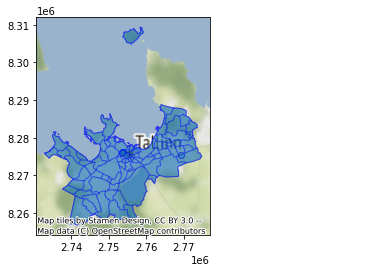

In [98]:
gdf_tal_soft = osmnx.geometries_from_place('Tallinn',tags=rel_tal_tags)
ax = gdf_tal_soft.to_crs(crs=crs_web).plot(edgecolor='blue', alpha=.3)
ctx.add_basemap(ax=ax, zoom=9)

In [99]:
gdf_tal_soft = gdf_tal_soft.loc['relation']


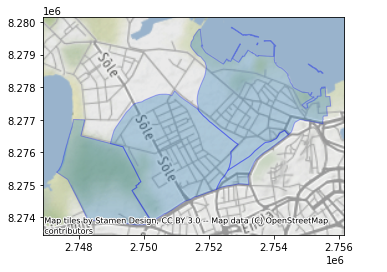

In [100]:
gdf_tal_aoi=\
gdf_tal_soft\
    .reset_index()\
    .set_index(['name','osmid'])\
    .loc[['Kelmiküla','Merimetsa', 'Pelgulinn', 'Kalamaja']]\
    .to_crs(crs=crs_web)
ax = gdf_tal_aoi.plot(edgecolor='blue', alpha=.3)
ctx.add_basemap(ax=ax, zoom=12)

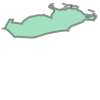

In [103]:
aoi = unary_union(list(gdf_tal_aoi.to_crs(crs=crs_gps).geometry))
aoi

In [107]:
streets_aoi = osmnx.graph_from_polygon(aoi)
print(streets_aoi.nodes)

[10578481, 10578496, 10578760, 10578773, 10578853, 10578897, 10579003, 11780790, 11780835, 11780841, 11780850, 11780857, 11780861, 11780862, 11780865, 11780904, 11780905, 11780906, 11780907, 11780908, 11780920, 11780940, 11780946, 11780960, 11780965, 11780981, 11781290, 11781293, 11781309, 11781316, 11781327, 11781333, 11781338, 11781344, 11781380, 11781383, 11781388, 11782291, 11782470, 11782476, 11782488, 11782502, 11782519, 11782535, 11782547, 11782553, 11782559, 11782564, 11782568, 11782571, 11782734, 11782736, 11782741, 11782749, 11782855, 11782859, 11782860, 11782993, 11789289, 56921073, 72311978, 72311980, 72311989, 72333204, 72333205, 72333207, 72333209, 73491688, 80939687, 80939693, 80940601, 146379902, 146379905, 146381141, 146382798, 146382801, 146384001, 146384002, 146385361, 146385362, 146386770, 146386772, 146386773, 146386774, 146391989, 146393150, 146394804, 146394948, 146396302, 146398002, 146399104, 146400916, 146402711, 146402713, 146402718, 146404560, 146404696, 146

In [108]:
display(streets_aoi.edges)

OutMultiEdgeView([(10578481, 10578496, 0), (10578481, 1696815513, 0), (10578481, 7363769346, 0), (10578496, 10578481, 0), (10578496, 5718625280, 0), (10578760, 5904633656, 0), (10578760, 636105706, 0), (10578760, 8512068348, 0), (10578773, 8512068285, 0), (10578773, 7760147921, 0), (10578773, 2408644668, 0), (10578773, 636105737, 0), (10578853, 636105705, 0), (10578853, 8918978434, 0), (10578853, 8918978429, 0), (10578897, 3674387084, 0), (10578897, 3674387075, 0), (10579003, 5932943933, 0), (10579003, 11782291, 0), (10579003, 4545745251, 0), (11780790, 1746798063, 0), (11780790, 1769371919, 0), (11780835, 2245176497, 0), (11780835, 5893721984, 0), (11780835, 5893721935, 0), (11780841, 2354993567, 0), (11780841, 4845132069, 0), (11780841, 2354993565, 0), (11780850, 9027692670, 0), (11780850, 6633359135, 0), (11780850, 6633359136, 0), (11780850, 6410093614, 0), (11780857, 4493694724, 0), (11780857, 4448106026, 0), (11780857, 2761562767, 0), (11780861, 146382801, 0), (11780861, 298086630

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_tal_aoi.to_crs(crs=crs_gps).plot(ax=ax, edgecolor='yellow', alpha=.3)
ax.set_title('Area of interest, road graph')

ctx.add_basemap(ax=ax, crs=crs_gps, zoom=13)
osmnx.plot_graph(streets_aoi, ax=ax, bgcolor='none', node_color='none', node_size=1,
                 edge_color='blue', edge_linewidth=.7)
plt.show()

In [ ]:
gdf_bal = osmnx.geocode_to_gdf('Toompuiestee 37/2, Tallinn, Estonia')
gdf_bal

In [ ]:
gdf_ron = osmnx.geocode_to_gdf('Hipodroomi 13, Tallinn, Estonia')
gdf_ron

In [ ]:
gdf_addr = gpd.GeoDataFrame(pd.concat([gdf_bal, gdf_ron]))\
    .assign(label=['Bus','Climb'], path=['start','stop'])\
    .set_index('path')\
    .to_crs(crs=crs_web)
gdf_addr

In [ ]:
lons,lats=np.vstack(gdf_addr.geometry.centroid.to_crs(crs=crs_gps).apply(lambda gdf: np.asarray(gdf.xy).reshape(-1)).values).T
lons,lats

In [ ]:
start, stop = osmnx.nearest_nodes(streets_aoi, lons, lats)
route = osmnx.shortest_path(streets_aoi, start, stop)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_tal_aoi.to_crs(crs=crs_gps).plot(ax=ax, edgecolor='yellow', alpha=.3)
ax.set_title('Shortest path...')
ctx.add_basemap(ax=ax, crs=crs_gps, zoom=14)
gdf_addr.to_crs(crs=crs_gps).plot(ax=ax, facecolor='red')
osmnx.plot_graph_route(streets_aoi, ax=ax, route=route, bgcolor='none', node_color='none', node_size=5,
                         edge_color='gray', edge_linewidth=2, route_color='blue', orig_dest_size=1,
                          route_linewidth=2)
#osmnx.plot_graph(streets_aoi, ax=ax, bgcolor='none', node_color='none', node_size=1,edge_color='gray', edge_linewidth=.7)

plt.show()

In [ ]:
# Q2

In [ ]:
overpass_q =\
'''
/* All the roads in the area of interest */

[out:json];
area["ISO3166-1"="EE"]->.eesti;
area(area.eesti)[name="Harju maakond"]->.harju;
rel(area.harju)[name~"Kalamaja|Kelmiküla|Merimetsa|Pelgulinn"];
map_to_area->.aoi;
(rel(area.aoi)[type="boundary"];way(area.aoi)[highway];);

(._;>;);   // Resolve nodes
out body;  // Collect everything
'''
overpass_r = overpass_client.query(overpass_q)

In [ ]:
df_nodes =\
pd.DataFrame([dict([(a,getattr(x,a)) for a in ['id','lat','lon']]) for x in overpass_r.nodes])\
    .set_index('id',drop=True)

In [ ]:
gdf_nodes = gpd.GeoDataFrame(
    df_nodes.assign(geometry=\
        df_nodes.groupby('id')\
            .apply(lambda df: df[['lon','lat']].values.reshape(-1))\
            .apply(Point))\
        .drop(columns=['lon','lat']),
    crs=crs_gps)

In [ ]:
df_ways_idx =\
pd.DataFrame(np.vstack([np.asarray([[w.id, n.id] for n in w.nodes])
                        for w in overpass_r.ways]),
             columns=['id','node'])\
    .set_index('id', drop=True)

In [ ]:
df_ways=\
    df_ways_idx.groupby('id').apply(lambda df: df.node.values)\
        .to_frame()\
        .rename(columns={0:'nodes'})

In [ ]:
df_ways=\
    pd.concat([pd.DataFrame(w.tags,index=[w.id]) for w in overpass_r.ways])\
        .join(df_ways)

In [ ]:
gdf_ways = gpd.GeoDataFrame(
    df_ways.assign(geometry=\
        df_ways.nodes.apply(lambda nodes: LineString(df_nodes.loc[nodes][['lon','lat']].values))),
    crs=crs_gps)

In [ ]:
df_rel_idx=\
    pd.concat(
        [pd.concat([pd.DataFrame({'way':m.ref, 'role':m.role}, index=[r.id]) for m in r.members])
         for r in overpass_r.relations])

In [ ]:
# Collect relation attributes
df_rels = pd.concat([pd.DataFrame(r.tags,index=[r.id]) for r in overpass_r.relations])

In [ ]:
# Skip the label-relations, take only outer-relations, compose way list for each relation
df_rels=\
    df_rels.assign(ways=\
        df_rel_idx\
            .reset_index()\
            .set_index(['role','index'])\
            .loc['outer']\
            .groupby('index')\
            .apply(lambda df: df.way.values))

In [ ]:
# Add the relation labels
df_rels=\
    df_rel_idx\
        .reset_index()\
        .set_index(['role','index'])\
        .loc['label']\
        .rename(columns={'way':'label'})\
        .join(df_rels)

In [ ]:
list(polygonize(gdf_ways.loc[df_rels.iloc[0].ways].geometry.values))[0]

In [ ]:
gdf_rels=\
gpd.GeoDataFrame(
    df_rels.assign(geometry=\
        df_rels\
            .groupby('index')\
            .apply(lambda df_rel: list(polygonize(gdf_ways.loc[df_rel.ways.values[0]].geometry.values))[0])),
    crs=crs_gps)

In [ ]:
np.vstack(gdf_nodes.to_crs(crs=crs_web).loc[gdf_rels.label].geometry.apply(lambda p: np.asarray(p.xy).reshape(-1)).values)

In [ ]:
gdf_roads=\
    gdf_ways[~np.in1d(df_ways.index.values, np.hstack(gdf_rels.ways.values))]\
        .dropna(axis=1)

In [ ]:
df_road_segs =\
    pd.concat([road2segs(gdf_roads.loc[way]) for way in gdf_roads.index])

In [ ]:
gdf_road_segs=\
    gpd.GeoDataFrame(
        df_road_segs.assign(geometry=\
            df_road_segs\
                .join(gdf_nodes, on='start')\
                .rename(columns={'geometry':'vtx1'})\
                .join(gdf_nodes, on='end')\
                .rename(columns={'geometry':'vtx2'})\
                [['vtx1','vtx2']].T.apply(LineString)),
        crs=crs_gps)

In [ ]:
# Remove the roads beyond the area of interes
p2_aoi = unary_union(list(gdf_rels.geometry.values))

In [ ]:
gdf_road_segs = gdf_road_segs[~gdf_road_segs.intersection(p2_aoi).apply(lambda x: x.is_empty)]

In [ ]:
# Calculate edge distances (meters)
# use estonian coordinate system here !!!
gdf_road_segs = gdf_road_segs.assign(dist=gdf_road_segs.to_crs(crs=crs_estonia).length)

In [ ]:
# Prpare the graph structure
gdf_g0 = gdf_road_segs.reset_index().set_index(['start','end'])
gdf_g0


In [ ]:
overpass_q =\
'''

[out:json];
area["ISO3166-1"="EE"]->.eesti;
area(area.eesti)[name="Harju maakond"]->.harju;
rel(area.harju)[name~"Kalamaja|Kelmiküla|Merimetsa|Pelgulinn"];
map_to_area->.aoi;
(
way(area.aoi)[building];
);
// Collect nodes for all the ways and relations
//   Geometries will be built manually
(._;>;);   // Resolve nodes
out body;  // Collect everything

'''

In [ ]:
overpass_r = overpass_client.query(overpass_q)

In [ ]:
# Collect the addresses
df_addr = pd.concat([pd.DataFrame(w.tags,index=[w.id]) for w in overpass_r.ways])

In [ ]:
# multiple entries for the climbing address, deletes one of them
df_addr = df_addr.drop(26874683)

In [ ]:
df_addr=\
    df_addr\
        .reset_index()\
        .set_index(['addr:street','addr:housenumber'])

In [ ]:
gdf_buildings=\
    gpd.GeoDataFrame(
        [{'id':w.id,'geometry':Polygon([(n.lon,n.lat) for n in w.nodes])} for w in overpass_r.ways],
        crs=crs_gps)\
    .set_index('id')

In [ ]:
gdf_path=\
    pd.concat([
        df_addr.loc['Toompuiestee'].loc[['37']],
        df_addr.loc['Hipodroomi'].loc[['13']]]
    ).set_index('index')\
    .assign(label=['Bus','Climb'])\
    .assign(path=['start','end'])\
    .dropna(axis=1)\
    .join(gdf_buildings)
gdf_path = gpd.GeoDataFrame(gdf_path)

In [ ]:
# Find the closes road ends
gdf_path_endnodes = gpd.GeoDataFrame(
    gdf_path.assign(geometry=gdf_path.to_crs(crs=crs_web).centroid)\
        .sjoin_nearest(gdf_nodes.to_crs(crs=crs_web))\
        .drop(columns=['geometry'])\
        .join(gdf_nodes, on='index_right'))

gdf_path_endnodes


In [ ]:


# Prepare bidirectional graph
gdf_g0_bi=\
    pd.concat([gdf_g0,
    gdf_g0.reset_index().rename(columns={'start':'end', 'end':'start'}).set_index(['start','end'])])

In [ ]:
import time

start = time.time()

# Implement Dijkstra
src,tgt = gdf_path_endnodes.index_right

# All the nodes (vertices in the graph)
# Table of previously visited nodes and correponding distances
df_dj = pd.DataFrame({'dist':np.inf, 'prev':None},
                     index=np.unique(gdf_road_segs[['start','end']].values))
# Init queue to all available nodes
q_dj = list(df_dj.index.values)

# Init src distance to 0
df_dj.loc[src] = 0

while len(q_dj) > 0:
    # Only use nodes currently in the queue
    df_qdj = df_dj.loc[q_dj]
    # Select the node with in minimal distance
    u = df_qdj.iloc[df_qdj.dist.argmin()].name
    # Terminate if target found
    if u == tgt:
        break
    # Remove selected node from the queue
    q_dj.remove(u)
    # Select neighbors of u
    uvs = gdf_g0_bi.loc[u].index
    # Only use those in the queue
    uvs = uvs[np.in1d(uvs, q_dj)]
    # Calculate alternative distance
    alt = gdf_g0_bi.loc[u].loc[uvs].dist+df_dj.loc[u].dist
    # Mask the neighbors with smaller alternative distance
    alt = alt[alt < df_dj.loc[alt.index].dist]
    # Assign previously visited nodes and alternative distances
    df_dj.loc[alt.index, 'prev'] = u
    df_dj.loc[alt.index, 'dist'] = alt
    
    
end = time.time()
print(end - start)

In [ ]:
df_dj.loc[tgt]

In [ ]:
# Collect the route
route = []
u = tgt
while u != src:
    route.append(u)
    u = df_dj.prev[u]


In [ ]:
gdf_route = gpd.GeoDataFrame({'geometry':[LineString(gdf_nodes.loc[route].geometry.values)]}, crs=crs_gps)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

gdf_path.to_crs(crs=crs_web).plot(ax=ax, color='red')
gdf_rels.set_index('name').to_crs(crs=crs_web).plot(ax=ax, color='blue', alpha=.1)
for rel in gdf_path.index:
    lon,lat = np.asarray(gdf_path.to_crs(crs=crs_web).centroid.loc[rel].xy).reshape(-1)
    ax.text(x=lon,y=lat,s=gdf_path.loc[rel].label)
gdf_route.to_crs(crs=crs_web).plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)


In [ ]:
#report

In [ ]:
gdf_dj_explored=\
gpd.GeoDataFrame(
df_dj.reset_index()\
    .rename(columns={'index':'end','prev':'start'})\
    .set_index(['start','end'])\
    .drop(columns=['dist'])\
    .join(gdf_g0_bi)\
    .dropna(),
crs=crs_gps)
gdf_dj_explored

In [ ]:
ax = gdf_dj_explored.plot()
gdf_route.plot(ax=ax, color='red')
gdf_rels.plot(ax=ax, color='red', alpha=.3)
ctx.add_basemap(ax=ax, crs=gdf_rels.crs, zoom=13)

In [ ]:
# Q3

In [ ]:
def straight_line_distance(p1, p2):
    seg = LineString([p1,p2]) 
    return gpd.GeoDataFrame({'geometry': [seg]}, crs=crs_gps).to_crs(crs_estonia).length.values[0]

In [ ]:
start = time.time()

# Implement Astar
src,tgt = gdf_path_endnodes.index_right

# All the nodes (vertices in the graph)
# Table of previously visited nodes and correponding distances
df_astar = pd.DataFrame({'dist':np.inf, 'prev':None, 'goal_dist':np.inf},
                     index=np.unique(gdf_road_segs[['start','end']].values))


# Init queue to all available nodes
q_astar = list(df_astar.index.values)

# Init src distance to 0
df_astar.loc[src, 'dist'] = 0
df_astar.loc[src, 'prev'] = 0

bus_coordinates = gdf_nodes.loc[src].geometry
climb_coordinates = gdf_nodes.loc[tgt].geometry

df_astar.loc[src, 'goal_dist'] = straight_line_distance(bus_coordinates, climb_coordinates)

df_astar.loc[src]


#start
while len(q_astar) > 0:
    
    # Only use nodes currently in the queue
    available_nodes = df_astar.loc[q_astar]
    # Select the node with in minimal sum of distance to source + estimated distance to target (straight line)
    u = available_nodes.iloc[(available_nodes.dist + available_nodes.goal_dist).argmin()].name
    
    # Terminate if target found
    if u == tgt:
        print('done')
        break
        
    # Remove selected node from the queue
    q_astar.remove(u)
    
    # Select neighbors of u
    neighbours = gdf_g0_bi.loc[u].index
    
    # Only use those still in the queue
    neighbours = neighbours[np.in1d(neighbours, q_astar)]
    
    # distance to neighbours over the currently discovered node 
    alt = gdf_g0_bi.loc[u].loc[neighbours].dist + df_astar.loc[u].dist
    
    # Mask the neighbours with smaller alternative distance
    alt = alt[alt < df_astar.loc[alt.index].dist]
    
    # Assign previously visited nodes, alternative distances and estimated distance to the target/ goal
    df_astar.loc[alt.index, 'prev'] = u
    df_astar.loc[alt.index, 'dist'] = alt
    
    df_astar.loc[alt.index, 'goal_dist'] = df_astar.loc[alt.index].apply(lambda node: straight_line_distance(gdf_nodes.loc[node.name].geometry, climb_coordinates), axis=1)
    
    
end = time.time()
print(end - start)

In [ ]:
df_astar[df_astar.dist < np.inf]

In [ ]:
df_astar.loc[tgt]

In [ ]:
# Collect the route
route = []
u = tgt
while u != src:
    route.append(u)
    u = df_astar.prev[u]


In [ ]:
gdf_route = gpd.GeoDataFrame({'geometry':[LineString(gdf_nodes.loc[route].geometry.values)]}, crs=crs_gps)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

gdf_path.to_crs(crs=crs_web).plot(ax=ax, color='red')
gdf_rels.set_index('name').to_crs(crs=crs_web).plot(ax=ax, color='blue', alpha=.1)
for rel in gdf_path.index:
    lon,lat = np.asarray(gdf_path.to_crs(crs=crs_web).centroid.loc[rel].xy).reshape(-1)
    ax.text(x=lon,y=lat,s=gdf_path.loc[rel].label)
gdf_route.to_crs(crs=crs_web).plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)

In [ ]:
gdf_astar_explored=\
gpd.GeoDataFrame(
df_astar.reset_index()\
    .rename(columns={'index':'end','prev':'start'})\
    .set_index(['start','end'])\
    .drop(columns=['dist'])\
    .join(gdf_g0_bi)\
    .dropna(),
crs=crs_gps)
gdf_astar_explored

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

gdf_astar_explored.plot(ax=ax)
gdf_route.plot(ax=ax, color='red')
gdf_rels.plot(ax=ax, color='red', alpha=.3)
ctx.add_basemap(ax=ax, crs=gdf_rels.crs, zoom=13)